In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import os
from torchvision import datasets, transforms, models
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision.transforms import v2

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

freeze = False
dropout = True
prob = 0.3
lr = 0.001
momentum = 0.9
step_size = 20
gamma = 0.1
criterion_name = 'Focal'
optimizer_name = 'Adam'
num_classes = 2
num_epochs = 30
batch_size = 30

In [8]:
transform = v2.Compose([
    v2.Resize(256),   #must same as here
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

train_data = datasets.ImageFolder(root=f"/kaggle/input/chest-xray-pneumonia/chest_xray/train", transform=transform)
val_data = datasets.ImageFolder(root=f"/kaggle/input/chest-xray-pneumonia/chest_xray/val", transform=transform)
test_data = datasets.ImageFolder(root=f"/kaggle/input/chest-xray-pneumonia/chest_xray/test", transform=transform)


train_size = len(train_data)
val_size = len(val_data)
test_size = len(test_data)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [9]:
print('Train dataset size:', train_size)
print('Validate dataset size:', val_size)
print('Test dataset size:', test_size)
class_names = train_data.classes
print('Class names:', class_names)

Train dataset size: 5216
Validate dataset size: 16
Test dataset size: 624
Class names: ['NORMAL', 'PNEUMONIA']


labels tensor([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1])


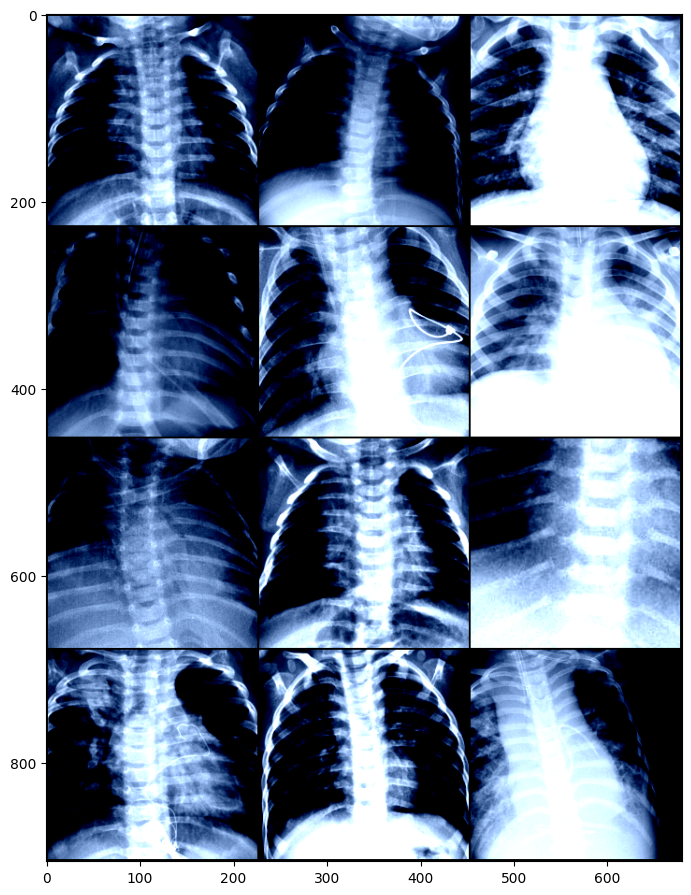

In [10]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset,batch_size = 12,shuffle=True)
    batch = next(iter(loader))
    images,labels = batch

    grid = torchvision.utils.make_grid(images,nrow = 3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels',labels)

show_transformed_images(train_data)

In [13]:
model = models.resnet18(weights=None,num_classes=5)
model.eval()
for param in model.parameters():
    param.requires_grad = False

In [14]:
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])


features_all = []
labels_all = []
with torch.no_grad():
    for loader in [train_loader, val_loader, test_loader]:
        for images, batch_labels in loader:
            batch_features = feature_extractor(images)
            batch_features = torch.flatten(batch_features, start_dim=1)
            features_all.append(batch_features)
            labels_all.append(batch_labels)
features_all = torch.cat(features_all, dim=0)
labels_all = torch.cat(labels_all, dim=0)

In [15]:
distances_all = pairwise_distances(features_all.numpy())
sigma_all = torch.median(torch.tensor(distances_all)).item()
similarities_all = torch.exp(-torch.tensor(distances_all)**2 / (2 * sigma_all**2))

# Compute t-SNE embeddings
tsne_all = TSNE(n_components=2, perplexity=30, verbose=1)
embeddings_all = tsne_all.fit_transform(similarities_all.numpy())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5856 samples in 0.015s...
[t-SNE] Computed neighbors for 5856 samples in 7.064s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5856
[t-SNE] Computed conditional probabilities for sample 2000 / 5856
[t-SNE] Computed conditional probabilities for sample 3000 / 5856
[t-SNE] Computed conditional probabilities for sample 4000 / 5856
[t-SNE] Computed conditional probabilities for sample 5000 / 5856
[t-SNE] Computed conditional probabilities for sample 5856 / 5856
[t-SNE] Mean sigma: 0.531808
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.242325
[t-SNE] KL divergence after 1000 iterations: 0.599475


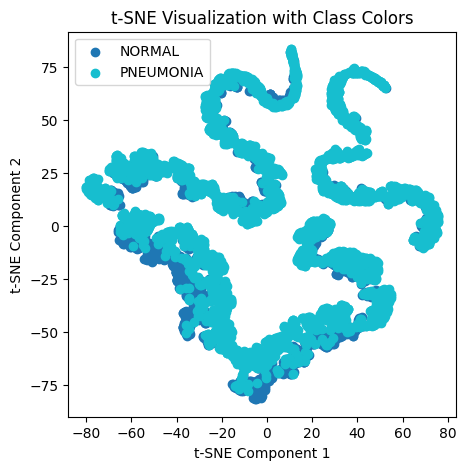

In [19]:
num_classes = len(np.unique(labels_all))
colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

# Plot t-SNE embeddings with colors
plt.figure(figsize=(5, 5))
for i in range(num_classes):
    plt.scatter(embeddings_all[labels_all == i, 0], embeddings_all[labels_all == i, 1], color=colors[i], label=class_names[i])

plt.title('t-SNE Visualization with Class Colors')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

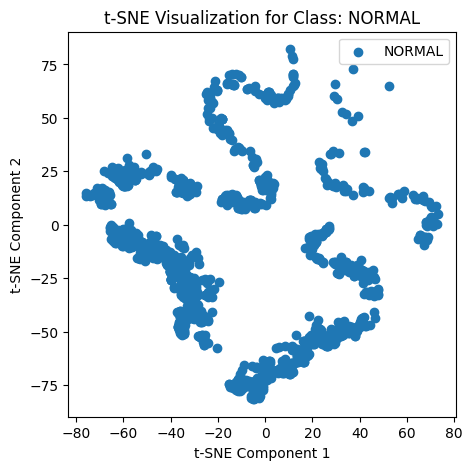

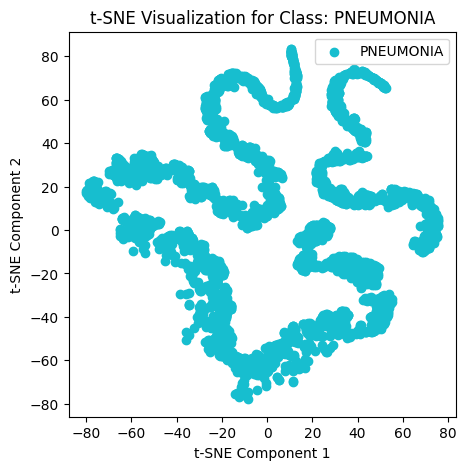

In [20]:
num_classes = len(class_names)
colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

# Create a separate plot for each class
for i in range(num_classes):
    # Select embeddings and labels for the current class
    class_embeddings = embeddings_all[labels_all == i]
    class_labels = labels_all[labels_all == i]

    # Plot t-SNE embeddings for the current class
    plt.figure(figsize=(5, 5))
    plt.scatter(class_embeddings[:, 0], class_embeddings[:, 1], color=colors[i], label=class_names[i])
    plt.title(f't-SNE Visualization for Class: {class_names[i]}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.show()